<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/ml/ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PPO CartPole

Use PPO (Proximal Policy Optimization) to solve CartPole game.

[OpenAI Gym CartPole](https://gym.openai.com/envs/CartPole-v0/) has four states, cart position, cart speed, pole angle, and pole speed. The actions are either going left or right. The objective is to keep pole from falling. Every move that doesn't lead to a fall gets reward 1.

PPO is off-policy TD method. It re-uses old experiences by importance sampling. Inherit notations from [reinforce notebook](./reinforce.ipynb),

$$
\begin{aligned}
J(\theta) &= E_{\tau \sim \pi_{\theta}(\tau)}[R(\tau)] \\
 &= \sum_{t=1}^T E_{(s_t, a_t) \sim \pi_{\theta}(s_t, a_t)}\left[ r(s_t, a_t) \right] \\
 &= \sum_{t=1}^T E_{(s_t, a_t) \sim \pi_{\theta'}(s_t, a_t)}\left[ \frac{\pi_{\theta}(s_t, a_t)}{\pi_{\theta'}(s_t, a_t)} r(s_t, a_t) \right] \\
 &\approx \sum_{t=1}^T E_{(s_t, a_t) \sim \pi_{\theta'}(s_t, a_t)}\left[ \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta'}(a_t|s_t)} r(s_t, a_t) \right] \\
\end{aligned}
$$

where last equation assumes $\pi_{\theta}(s_t) \approx \pi_{\theta'}(s_t)$, or state $s_t$ has similar probability of occurrence under two policies.

PPO improves TRPO (Trust Region Policy Optimization) by moving KL-Divergence condition from constraints to Lagrangian penalties in the objective function. KL-Divergence is a better measure than simple parameter distance.

$$
J_{PPO}^{\theta'}(\theta)=E_{(s_t, a_t) \sim \pi_{\theta'}(s_t, a_t)}\left[ \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta'}(a_t|s_t)} A^{\theta'}(s_t, a_t) \right] - \beta KL(\theta, \theta')
$$

PPO2 replaces KL-Divergence by eplison clips to keep policies close.

This notebook follows closely [here](https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book/blob/master/ch14-%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0/ppo_tf_cartpole.py). Just added some comments for my own understanding.


[Reference]
* Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.
* [RL by David Silver](https://www.davidsilver.uk/teaching/)
* [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/algorithms/ppo.html)
* [OpenAI Baseline](https://github.com/openai/baselines/tree/master/baselines/ppo2)
* [Deep Learning with TensorFlow](https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book)

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gym
from collections import namedtuple
import random
import tensorflow as tf
from tensorflow import keras

In [10]:
env = gym.make('CartPole-v1')
env.seed(1234)
tf.random.set_seed(1234)
np.random.seed(1234)

In [11]:
# Hyperparameters
episodes = 500
gamma = 0.98
epsilon = 0.2
batch_size = 32

In [12]:
Transition = namedtuple('Transition', ['state', 'action', 'a_log_prob', 'reward', 'next_state'])

class Actor(keras.Model):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = keras.layers.Dense(100, kernel_initializer='he_normal')
        self.fc2 = keras.layers.Dense(2, kernel_initializer='he_normal')

    def call(self, inputs):
        """
        input: s, output: pi(a|s)
        """
        x = tf.nn.relu(self.fc1(inputs))
        x = self.fc2(x)
        x = tf.nn.softmax(x, axis=1)
        return x

class Critic(keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = keras.layers.Dense(100, kernel_initializer='he_normal')
        self.fc2 = keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
        """
        input: s, output: v(s)
        """
        x = tf.nn.relu(self.fc1(inputs))
        x = self.fc2(x)
        return x

In [13]:
class PPO2():
    def __init__(self):
        super(PPO2, self).__init__()
        self.actor = Actor()
        self.critic = Critic()
        self.buffer = []              # experience buffer
        self.actor_optimizer = keras.optimizers.Adam(1e-3)
        self.critic_optimizer = keras.optimizers.Adam(3e-3)

    def select_action(self, s):
        s = tf.constant(s, dtype=tf.float32)         # [4]
        s = tf.expand_dims(s, axis=0)       # [4] => [1,4]
        prob = self.actor(s)           # [1, 2]
        a = tf.random.categorical(tf.math.log(prob), 1)[0]    # [1, 1] ==> [1]
        a = int(a)  # Tensor ==> int
        return a, float(prob[0][a])           # a, prob(a|s)

    def get_value(self, s):
        s = tf.constant(s, dtype=tf.float32)       # [4]
        s = tf.expand_dims(s, axis=0)      # [4] => [1,4]
        v = self.critic(s)[0]           # [1, 1] ==> [1]
        return float(v)                 # v(s)

    def store_transition(self, transition):
        # store experience
        self.buffer.append(transition)

    def optimize(self):
        # convert sample to tensor
        state = tf.constant([t.state for t in self.buffer], dtype=tf.float32)         # (buff, 4)
        action = tf.constant([t.action for t in self.buffer], dtype=tf.int32)         # (buff,)
        action = tf.reshape(action,[-1,1])                             # (buff,) ==> (buff, 1)
        reward = [t.reward for t in self.buffer]
        old_action_log_prob = tf.constant([t.a_log_prob for t in self.buffer], dtype=tf.float32)    # (buff,)
        old_action_log_prob = tf.reshape(old_action_log_prob, [-1,1])                 # (buff, ) ==> (buff, 1)
        # rewards to go, assuming one MC
        R = 0
        Rs = []
        for r in reward[::-1]:
            R = r + gamma * R
            Rs.insert(0, R)
        Rs = tf.constant(Rs, dtype=tf.float32)                # (buff,)
        # Reuse buffer roughly 10 times
        for _ in range(round(10*len(self.buffer)/batch_size)):
            # sample batch size
            index = np.random.choice(np.arange(len(self.buffer)), batch_size, replace=False)   # permutation
            with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
                v_target = tf.expand_dims(tf.gather(Rs, index, axis=0), axis=1)      # [b,1]
                v = self.critic(tf.gather(state, index, axis=0))              # baseline, [b,4] ==> [b, 1]
                delta = v_target - v                   # advantage, [b, 1]
                advantage = tf.stop_gradient(delta)     # freeze advantage in optimizing PPO2 loss, [b, 1]
                # retrieve pi(at|st)
                a = tf.gather(action, index, axis=0)         # [b, 1]
                pi = self.actor(tf.gather(state, index, axis=0))        # [b, 4] ==> [b, 2]
                indices = tf.expand_dims(tf.range(a.shape[0]), axis=1)        # [b, 1]
                indices = tf.concat([indices, a], axis=1)               # [32, 2]
                pi_a = tf.gather_nd(pi, indices)    # pi(at|st), [b]
                pi_a = tf.expand_dims(pi_a, axis=1)  # [b]=> [b,1] 
                # importance sampling
                ratio = (pi_a / tf.gather(old_action_log_prob, index, axis=0))   # [b, 1]
                surr1 = ratio * advantage                  # [b, 1]
                surr2 = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon) * advantage   # clipped, [b, 1]
                policy_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))   # PPO2 loss function
                # v(s) close to MC rewards
                value_loss = keras.losses.MSE(v_target, v)             # (b,)
            # optimize actor
            grads = tape1.gradient(policy_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(grads, self.actor.trainable_variables))
            # optimize critic
            grads = tape2.gradient(value_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        self.buffer = []  # clear buffer

In [14]:
agent = PPO2()
returns = [] # average returns over 20 episodes
total = 0 # total returns
for i_epoch in range(episodes):
    state = env.reset() # reset to initial state
    for t in range(500): # maximum 500 steps
        action, action_prob = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)

        trans = Transition(state, action, action_prob, reward, next_state)
        agent.store_transition(trans)

        state = next_state
        total += reward
        if done:
            if len(agent.buffer) >= batch_size:
                agent.optimize() # train agent
            break

    if i_epoch % 20 == 0:
        returns.append(total/20)
        total = 0
        print(i_epoch, returns[-1])

0 0.6
20 38.25
40 56.3
60 141.85
80 264.65
100 415.75
120 426.4
140 442.7
160 446.25
180 448.15
200 472.2
220 410.1
240 423.1
260 473.75
280 478.4
300 472.65
320 412.25
340 490.5
360 462.05
380 390.15
400 368.2
420 357.0
440 469.85
460 500.0
480 474.75


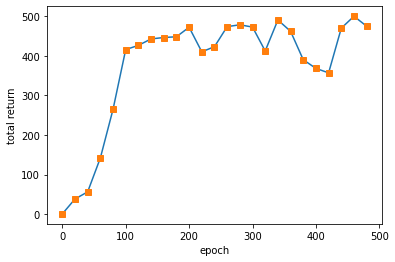

In [16]:
plt.plot(np.arange(len(returns))*20, returns)
plt.plot(np.arange(len(returns))*20, returns, 's')
plt.xlabel('epoch')
plt.ylabel('total return')
plt.show()